# Projeto 3 – Validação cruzada e o dilema viés x variância
---------------

**Atualização do cliente:** 

  + -2: nao houve uso da conta; -1 pagamento em dia; 0 pagamento mínimo foi realizado.
  + Vimos nos projetos anteriores que PAY n, (n ≥ 2) não pode ser considerada em nossa análise. Vamos remover todas essas
    features.
    
    
    
---------------------

**Este projeto**
No projeto anterior, empregamos a regressão logística sem nos preocuparmos com o papel do hiperparâmetro C (notação do scikit-learn) do modelo.


Dependendo do valor de C, o modelo pode se ajustar de maneira insuficiente ao conjunto de treinamento (*underfitting*) ou sobreajustar-se (*overfitting*). O objetivo deste projeto e determinar o C ideal para o nosso estudo de caso e concluir se há ou não *under* ou *overfitting*. Para garantir a generalidade de sua análise, vamos fazer a avaliação cruzada ($k-fold$ com $k=4$).

In [1]:
# l1 x l2

# dados: normalizar x standartize

# amostragem estratificada ou não

## Importando os dados

In [2]:
### Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Customização Gráfica
pd.options.display.max_columns = 24
pd.options.display.precision = 3

sns.set(style="ticks", context="notebook", palette='pastel')
plt.style.use("dark_background")

plt.rcParams['figure.figsize'] = (15,6)


df = pd.read_csv(r'../Projeto 1 - Exploração e eliminação de dados espúrios/base_limpa.csv')
df.head()

,ID,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,1,24,2.0,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,26,-1.0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,34,0.0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,1,37,0.0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,2,1,57,-1.0,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
### Removendo as PAY n, (n ≥ 2) 

colunas_para_remover = 'PAY_2 PAY_3 PAY_4 PAY_5 PAY_6'.split()

df = df.drop(columns=colunas_para_remover)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29687 entries, 0 to 29686
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          29687 non-null  object 
 1   LIMIT_BAL                   29687 non-null  int64  
 2   EDUCATION                   29687 non-null  int64  
 3   MARRIAGE                    29687 non-null  int64  
 4   AGE                         29687 non-null  int64  
 5   PAY_1                       26666 non-null  float64
 6   BILL_AMT1                   29687 non-null  int64  
 7   BILL_AMT2                   29687 non-null  int64  
 8   BILL_AMT3                   29687 non-null  int64  
 9   BILL_AMT4                   29687 non-null  int64  
 10  BILL_AMT5                   29687 non-null  int64  
 11  BILL_AMT6                   29687 non-null  int64  
 12  PAY_AMT1                    29687 non-null  int64  
 13  PAY_AMT2                    296

In [5]:
### Por enquanto vamos remover os nulos de nossa análise, por serem ~10% apenas dos dados
df = df.dropna()
df.reset_index(drop=True, inplace=True)

## Train Test Split

Como vimos antes a amostragem estratificada se mostrou superior do que a randomica. Vamos seguir utilizar então o StratifiedShuffleSplit.

Usaremos agora o dataset completo com todas as features

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=21)

In [7]:
cols = df.columns

target = 'default payment next month'
X_cols = [x for x in cols if x != target]
#X_cols.remove('PAY_1')

X = df[X_cols]
y = df[target]


for train_index, test_index in split.split(df, y):
    train_strat = df.loc[train_index]
    test_strat = df.loc[test_index]

X_train, y_train = train_strat[X_cols], train_strat[target]
X_test, y_test = test_strat[X_cols], test_strat[target]

## MinMaxScaler x StandartScaler

--------------------------------------------------------

$$Normalization: \frac{(X - X_{min})}{X_{max} - X_{min}}$$

$$Standardization: \frac{(X - \bar{X})}{\bar{Var}}$$

---------------------
Os dois métodos mais usados para reescalar os dados, qual seria o melhor para a nossa ocasião?
Aqui vai um comparativo entre os dois métodos:

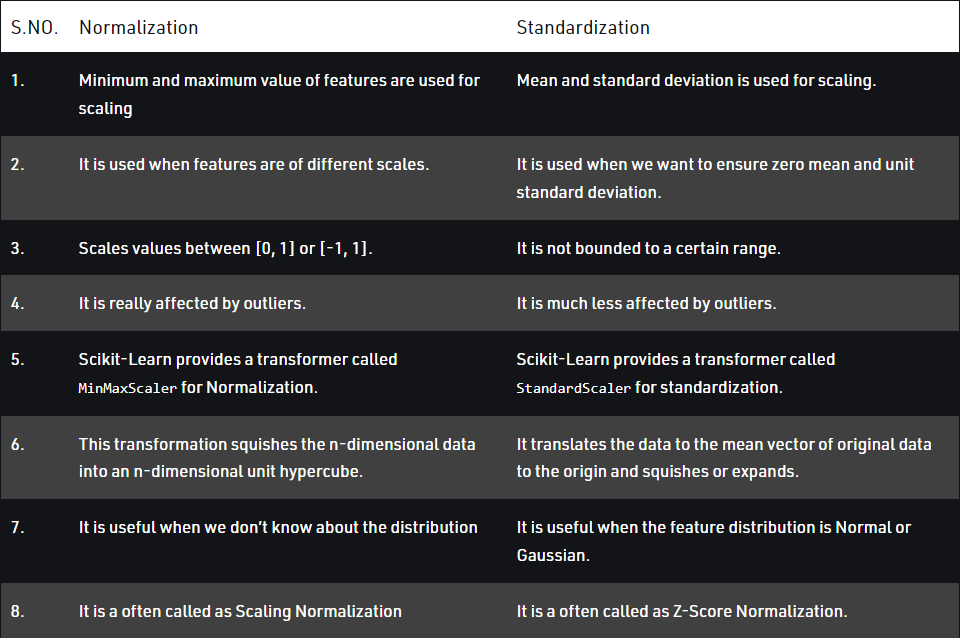

ref: https://www.geeksforgeeks.org/normalization-vs-standardization/

Ou seja, o Normalizer fixa a escala para ter o mínimo como 0 e o máximo como 1, já o Standardize reparametriza os dados para ter uma média 0 e um desvio padrão 1.

Como não fizemos o estudo sobre os outliers o Standardize sai na frente por ter menor impacto com esses pontos, entretanto o ideal é testar nossos dados para ver se encaixam numa distribuição normal.

In [8]:
## Fazendo o Teste de Normalidade
from scipy.stats import normaltest

def testando_normalidade(dados):    
    for feature in dados.select_dtypes(include='number'):
        alpha = 0.05
        k2, p = normaltest(dados[feature])

        # Hipotese nula: Os dados seguem distribuição normal
        # Hipotese alternativa: Os dados não seguem distribuição normal
        
        print('\nFeature Testada', feature)
        
        if p < alpha:
            print("A hipótese nula pode ser rejeitada, os dados não seguem distribuição normal")
        else:
            print("A hipótese nula não pode ser rejeitada, os dados seguem distribuição normal")
            
testando_normalidade(X_train)


Feature Testada LIMIT_BAL
A hipótese nula pode ser rejeitada, os dados não seguem distribuição normal

Feature Testada EDUCATION
A hipótese nula pode ser rejeitada, os dados não seguem distribuição normal

Feature Testada MARRIAGE
A hipótese nula pode ser rejeitada, os dados não seguem distribuição normal

Feature Testada AGE
A hipótese nula pode ser rejeitada, os dados não seguem distribuição normal

Feature Testada PAY_1
A hipótese nula pode ser rejeitada, os dados não seguem distribuição normal

Feature Testada BILL_AMT1
A hipótese nula pode ser rejeitada, os dados não seguem distribuição normal

Feature Testada BILL_AMT2
A hipótese nula pode ser rejeitada, os dados não seguem distribuição normal

Feature Testada BILL_AMT3
A hipótese nula pode ser rejeitada, os dados não seguem distribuição normal

Feature Testada BILL_AMT4
A hipótese nula pode ser rejeitada, os dados não seguem distribuição normal

Feature Testada BILL_AMT5
A hipótese nula pode ser rejeitada, os dados não seguem d

Nenhuma das variáveis segue uma distribuição normal, portanto usar o Standardize como scaler não vai ser a melhor escolha, vamos utilizar então o Normalizer.

In [10]:
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler()

x_train_scaled = norm.fit_transform(X_train.select_dtypes(include='number'))

In [11]:
x_train_scaled

array([[0.2       , 0.5       , 0.66666667, ..., 0.00074873, 0.01499546,
        0.00074906],
       [0.325     , 0.33333333, 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [0.2       , 0.16666667, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0625    , 0.16666667, 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [0.025     , 0.16666667, 0.66666667, ..., 0.        , 0.00234451,
        0.00510719],
       [0.1875    , 0.16666667, 0.66666667, ..., 0.01058807, 0.01266033,
        0.00945777]])

## Tuning Params

Essa etapa é muito importante para otimizar o nosso modelo, dificilmente será a melhor escolha usar um modelo com os parâmetros *default* atriuidos a ele, por isso modificamos os parâmetros em que acreditamos que haverá um ganho na função risco e testamos para ver se isso se concretiza.

Para isso usaremos uma outra ferramenta muito importante, a validação cruzada. Consiste em dividir nossos dados de treino em n parcelas, então treinamos o modelo por exemplo em n-1 dessas partições e validamos na 1 restante, depois mudamos a ordem de treino/validação e treinamos o modelo em um conjunto semi-novo e validamos no que restou, repetimos esse processo para garantir que o modelo não sobreajuste e fique especialista apenas naquele conjunto de dados, o que queremos é a generalização desse modelo.

Ou seja, colocamos vários modelos para "batalhar" com diferentes parâmetros em diferentes "campos", o que se sair melhor no geral é o nosso modelo vencedor.

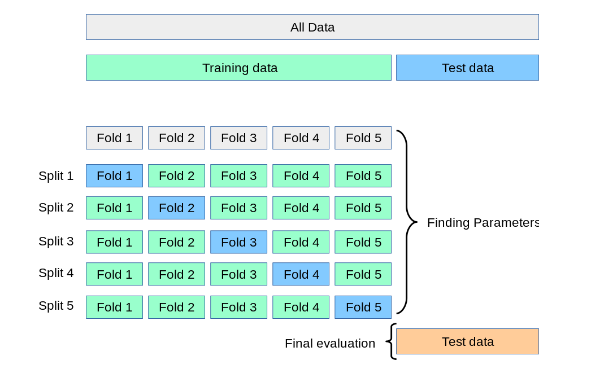

ref: https://scikit-learn.org/stable/modules/cross_validation.html

In [12]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# Parametros a serem testados
params = {'penalty': ['l1', 'l2', 'elasticnet'],
         'C': np.arange(.25, 4.25, .25),
         'solver': ['saga', 'liblinear']}

rs_cv = RandomizedSearchCV(estimator=LogisticRegression(),
                          param_distributions=params,
                          cv=4, scoring='roc_auc_ovr_weighted')

In [13]:
busca = rs_cv.fit(x_train_scaled, y_train)

In [14]:
pd.DataFrame(busca.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,4.601e-02,2.945e-03,0.005,9.521e-04,liblinear,l2,2.0,"{'solver': 'liblinear', 'penalty': 'l2', 'C': ...",0.709,0.729,0.725,0.711,0.719,0.009,5
1,7.508e-04,4.335e-04,0.000,0.000e+00,liblinear,elasticnet,1.0,"{'solver': 'liblinear', 'penalty': 'elasticnet...",NaN,NaN,NaN,NaN,NaN,NaN,8
2,3.230e-02,5.039e-03,0.004,1.122e-03,liblinear,l2,0.5,"{'solver': 'liblinear', 'penalty': 'l2', 'C': ...",0.709,0.727,0.724,0.710,0.718,0.008,7
3,3.583e-01,2.392e-02,0.004,8.196e-04,saga,l1,3.0,"{'solver': 'saga', 'penalty': 'l1', 'C': 3.0}",0.710,0.732,0.727,0.713,0.720,0.009,3
4,1.646e-03,4.162e-04,0.000,0.000e+00,liblinear,elasticnet,2.5,"{'solver': 'liblinear', 'penalty': 'elasticnet...",NaN,NaN,NaN,NaN,NaN,NaN,8
5,5.048e-01,1.028e-01,0.004,9.163e-04,liblinear,l1,3.0,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.710,0.732,0.727,0.713,0.720,0.009,2
6,6.226e-02,1.091e-02,0.004,1.025e-03,saga,l2,0.75,"{'solver': 'saga', 'penalty': 'l2', 'C': 0.75}",0.709,0.728,0.724,0.710,0.718,0.008,6
7,1.845e-01,4.261e-02,0.003,5.743e-04,saga,l2,3.0,"{'solver': 'saga', 'penalty': 'l2', 'C': 3.0}",0.709,0.730,0.725,0.712,0.719,0.009,4
8,8.621e-04,5.272e-04,0.000,0.000e+00,liblinear,elasticnet,0.5,"{'solver': 'liblinear', 'penalty': 'elasticnet...",NaN,NaN,NaN,NaN,NaN,NaN,8
9,4.983e-01,4.676e-02,0.003,7.265e-04,liblinear,l1,3.75,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.710,0.732,0.727,0.713,0.721,0.009,1


In [15]:
print('Melhores Parâmetros:\n',busca.best_params_)

Melhores Parâmetros:
 {'solver': 'liblinear', 'penalty': 'l1', 'C': 3.75}


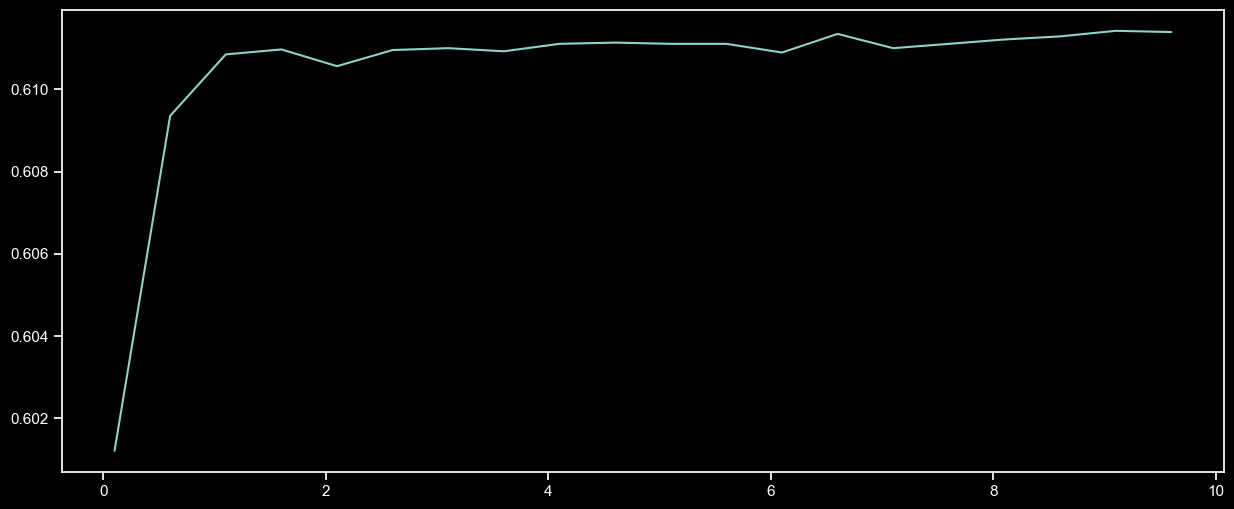

In [16]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, recall_score

def avaliando_C(x_train, y_train):
    scores = []
    range_ = np.arange(0.1, 10, 0.5)
    for C in range_:
        lr = LogisticRegression(penalty='l1', solver='liblinear', C=C)
        fit = lr.fit(x_train, y_train)
        
        pred = fit.predict(x_train)
        roc_area = roc_auc_score(y_train, pred)
        
        scores.append(roc_area)
        
    sns.lineplot(x=range_, y=scores)
    
avaliando_C(x_train_scaled, y_train)

-------------------
## Polinomial Features

Gerar uma nova matriz de características constituída por todas as combinações polinomiais das características com grau inferior ou igual ao grau especificado. Por exemplo, se uma amostra de entrada for bidimensional e da forma [a, b], as características polinomiais de grau 2 são [1, a, b, a^2, ab, b^2].

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('Polynomial Features', PolynomialFeatures(degree=2))
])

pipe_fitted = pipe.fit_transform(X_train.select_dtypes(include='number'))

In [19]:
busca_pf = rs_cv.fit(x_train_scaled, y_train)
busca_pf.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 3.75}

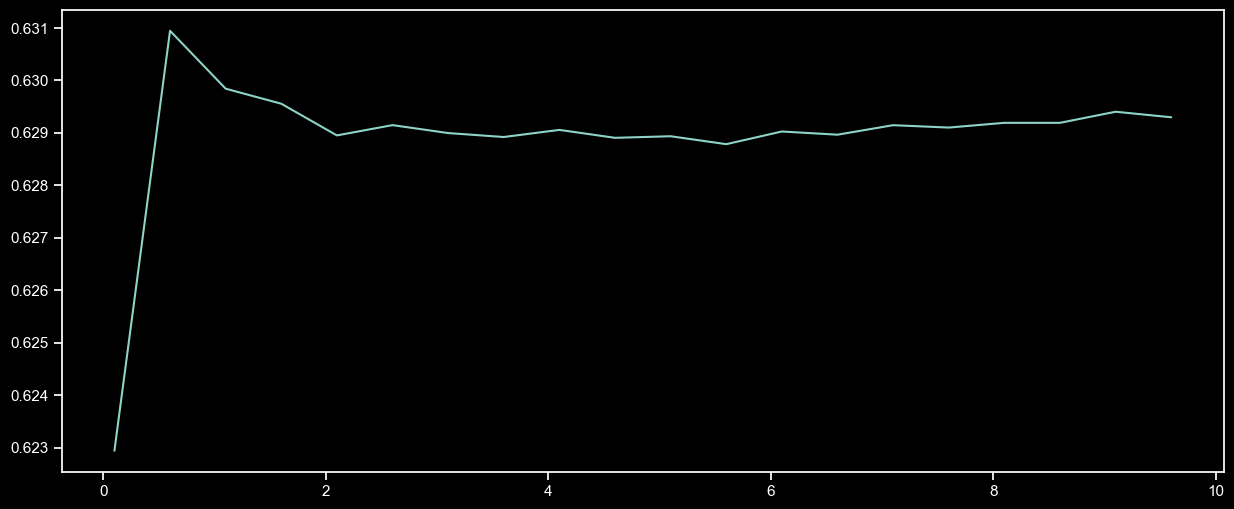

In [20]:
avaliando_C(pipe_fitted, y_train)

Ganhamos alguns pontos com a ajuda da ferramenta PolynomialFeatures!!